In [1]:
display(HTML("<style>.container { width:100% !important; }</style>"))

HTML{String}("<style>.container { width:100% !important; }</style>")

#### MIT License (c) 2019 by Andrew Lyasoff

#### Jupyter notebook written in Julia 1.1.0. It illustrates the construction of univariate histograms and the Monte Carlo simulation technique for multivariate Gaussian samples with a given covariance matrix. See (3.67), p. 91, in "Stochastic Methods in Asset Pricing."

In [1]:
using LinearAlgebra
using SpecialFunctions
using StatsBase
using Random
using Plots
pyplot()

Plots.PyPlotBackend()

We write our own histogram function. It takes as an input a single 1-dimensional array of data. The number of bins in the histogram is determined automatically by using the Diaconis-Friedman rule. The function returns two arrays: the mid-points of the bins and the (unnormalized) heights of the bars.

In [2]:
function hstgram(data_sample::Array{Float64,1})
    data_sorted=sort(data_sample)
    first=data_sorted[1]
    last=data_sorted[end]
    nmb=length(data_sorted)
    IQR=percentile(data_sorted,75)-percentile(data_sorted,25)
    bin_size_loc = 2*IQR*(nmb^(-1.0/3))
    num_bins=Int(floor((last-first)/bin_size_loc))
    bin_size=(last-first)/(num_bins)
    bin_end_points=[first+(i-1)*bin_size for i=1:(num_bins+1)]
    ahist_val=[length(data_sorted[data_sorted .< u]) for u in bin_end_points]
    hist_val=[ahist_val[i+1]-ahist_val[i] for i=1:num_bins]
    mid_bins=[first-bin_size/2+i*bin_size for i=1:num_bins]
    return mid_bins, hist_val
end

hstgram (generic function with 1 method)

First, create data sampled from the standard univariate normal density.

In [3]:
val=(x->((2*π)^(-1/2)*exp(-x^2/2))).(-3.3:0.05:3.3);

Now create 10000 randomly sampled points from the standard univariate Gaussian law. Note that the random numbers generator is called in such a way that it generates the same sample each time it is called. Notice also the normalization of the heights of the bars meant to ensure that the empirical density integrates to 1 (i.e., the area of the histogram equals 1).

In [4]:
#Random.seed!(0xabcdef12); # if needed to recover the same data

In [5]:
nval=randn!(zeros(10000));
U,V=hstgram(nval);
VV=V/(sum(V)*(U[2]-U[1]));

See the total number of bins:

In [6]:
length(VV)

65

We now plot the histogram created from the data against the standard normal density.

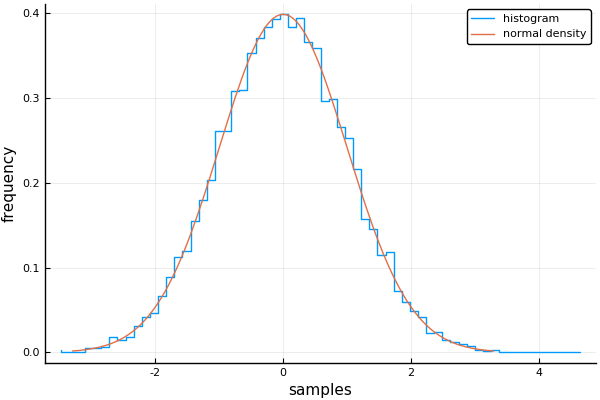

In [7]:
plot(U.+(U[2]-U[1])/2,VV,line=(:steppre,1),linewidth=0.05,label="histogram")
xlabel!("samples")
ylabel!("frequency")
plot!(-3.3:0.05:3.3,val,label="normal density")

Generate another sample:

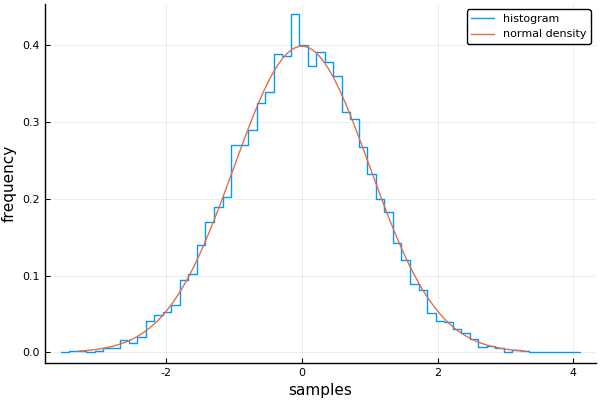

In [8]:
nval=randn(10000);
U,V=hstgram(nval);
VV=V/(sum(V)*(U[2]-U[1]));
plot(U.+(U[2]-U[1])/2,VV,line=(:steppre,1),linewidth=0.05,label="histogram")
xlabel!("samples")
ylabel!("frequency")
plot!(-3.3:0.05:3.3,val,label="normal density")

Univariate Gaussian samples can be generated also by transformung an uniformly distributed sample in $[0,1[$ (this method may be less reliable).

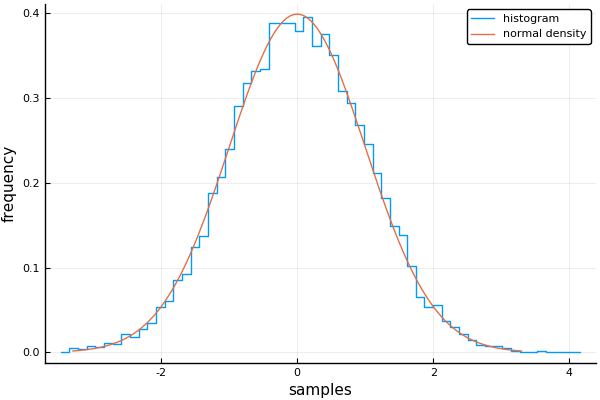

In [9]:
uval=rand(10000);
nval=(x->sqrt(2)*erfinv(2*x-1)).(uval);
U,V=hstgram(nval);
VV=V/(sum(V)*(U[2]-U[1]));
plot(U.+(U[2]-U[1])/2,VV,line=(:steppre,1),linewidth=0.05,label="histogram")
xlabel!("samples")
ylabel!("frequency")
plot!(-3.3:0.05:3.3,val,label="normal density")

Now we generate 10000 samples from the bi-variate Gaussian distribution with independent and standard normal marginals.

In [10]:
nnval=randn!(zeros(10000));

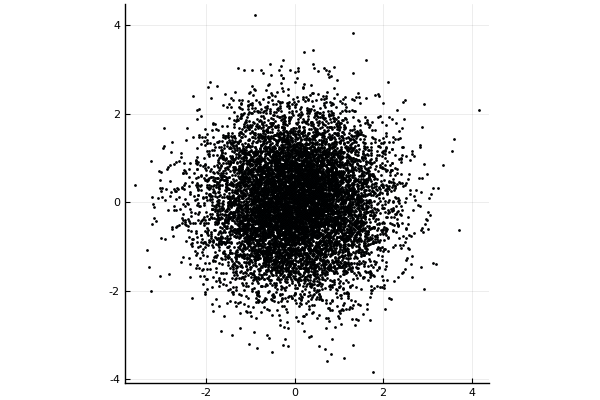

In [11]:
scatter(nval,nnval,ratio=1,markersize=1,label="")

First, create a 2x2 matrix that is positive definite and symmetric (a candidate covariance matrix). Check if it is indeed positive definite by computing the eigenvalues.

In [18]:
A=rand(2,2);
#Cov=A'A; # another alternative that always yields a positive definite matrix
Cov=Symmetric(A); # may not produce a positive definite matrix

In [19]:
eigvals(Cov) # repeat the previous cell if the eigenvalues are not positive

2-element Array{Float64,1}:
 0.11941681556756797
 1.1225976183189443 

Now generate the "square-root" of the covariance matrix by using either the spectral decomposition or the Cholesky factorization.

In [20]:
eigdCov=Diagonal(eigvals(Cov).^0.5)
eigCov=eigvecs(Cov); # matrix of eigen vectors
chlCov=cholesky(Cov); # Cholesky "square root" of Cov
MM=eigdCov*eigCov; # Spectral "square root" of Cov

Check that the factorizations give what is expected:

In [21]:
Cov-MM'*MM

2×2 Array{Float64,2}:
 0.0          5.55112e-17
 5.55112e-17  5.55112e-17

In [22]:
Cov-chlCov.L*chlCov.U

2×2 Array{Float64,2}:
  1.11022e-16  -5.55112e-17
 -5.55112e-17   0.0        

In [27]:
Cov-(chlCov.U)'chlCov.U

2×2 Array{Float64,2}:
  1.11022e-16  -5.55112e-17
 -5.55112e-17   0.0        

In [28]:
eigCov'eigCov # eigCov should be an orthogonal matrix

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

Transform the randomly generated standard bi-variate sample through the "square root" of the covariance matrix.

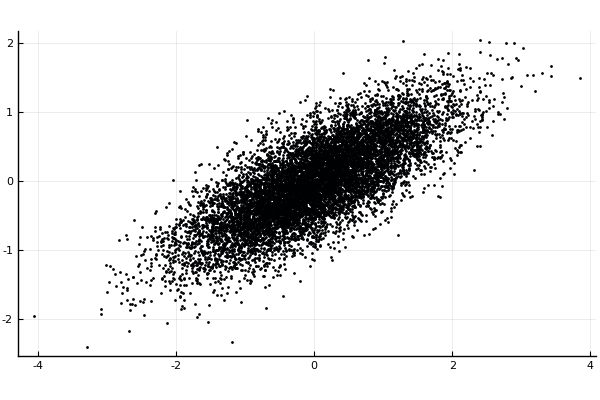

In [35]:
#method 1
NN=hcat(nval,nnval)';
data_2_dim=MM'NN;
scatter(data_2_dim[1,:],data_2_dim[2,:],ratio=1,markersize=1,label="")

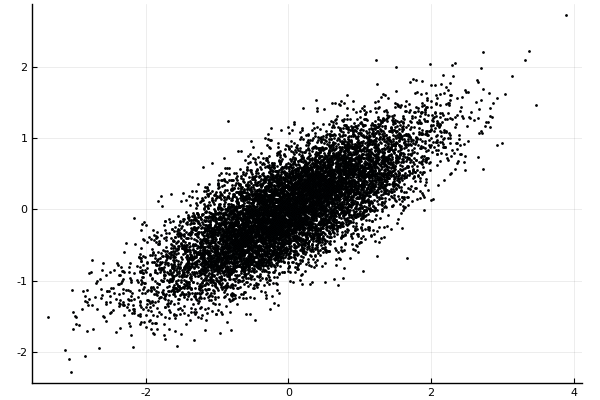

In [36]:
#method 2
data_2_dim=(chlCov.L)*NN;
scatter(data_2_dim[1,:],data_2_dim[2,:],ratio=1,markersize=1,label="")